_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install matplotlib==3.7.1
    !pip install pdpbox
    !pip install scikit-learn==1.1.3
    !pip install --upgrade pdpbox


# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`).

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [3]:
# YOUR CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, RocCurveDisplay
import xgboost as xgb
from pdpbox import pdp, info_plots
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance, plot_partial_dependence



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [4]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url, index_col='Inspection ID')
# YOUR CODE HERE
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
df.set_index('Inspection Date', inplace=True)
df.index.name = 'Inspection Date'

print(df.head())
print(df.info())

                                              DBA Name  \
Inspection Date                                          
2017-09-15                 TOM YUM RICE & NOODLE, INC.   
2011-10-20       FILLING STATION  & CONVENIENCE  STORE   
2016-04-05                                    A P DELI   
2016-04-29                FRANK'S CHICAGO SHRIMP HOUSE   
2011-01-10                                     MORRILL   

                                              AKA Name  License #  \
Inspection Date                                                     
2017-09-15                                TOM YUM CAFE  2354911.0   
2011-10-20       FILLING STATION  & CONVENIENCE  STORE  1044901.0   
2016-04-05                                    A P DELI    47405.0   
2016-04-29                FRANK'S CHICAGO SHRIMP HOUSE     6414.0   
2011-01-10                                     MORRILL    24571.0   

                 Facility Type             Risk                       Address  \
Inspection Date             

**Task 1 Test**

In [5]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [6]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'
# YOUR CODE HERE
print(leaky_col)

Serious Violations Found


**Task 2 Test**

In [7]:
'''T2 Test'''
# This is a hidden test.
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [10]:
'''T3. Write wrangle function.'''
def wrangle(df):
    """
    Remove the 'leaky' column, high-cardinality categorical columns,
    categorical columns with only one category, and numerical identifier columns.
    """
    # Remove the 'leaky' column
    df = df.drop(columns='Serious Violations Found')

    # Identify high-cardinality categorical columns
    high_cardinality_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() > 500]

    # Identify categorical columns with only one category
    single_category_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() == 1]

    # Identify numerical identifier columns
    numerical_id_cols = [col for col in df.select_dtypes(include='number').columns if df[col].nunique() == len(df)]

    # Add specific columns to remove
    cols_to_remove = high_cardinality_cols + single_category_cols + numerical_id_cols

    # Ensure 'License #' and 'Inspection ID' are removed if present
    cols_to_remove += [col for col in ['License #', 'Inspection ID'] if col in df.columns]

    # Drop the identified columns
    df = df.drop(columns=cols_to_remove)

    return df

# Apply the wrangle function to the DataFrame
df = wrangle(df)

# Display the first few rows to verify
print(df.head())
print(df.columns)


                 Facility Type             Risk     City      Zip  \
Inspection Date                                                     
2017-09-15          Restaurant    Risk 1 (High)  CHICAGO  60657.0   
2011-10-20       Grocery Store     Risk 3 (Low)  CHICAGO  60636.0   
2016-04-05          Restaurant    Risk 1 (High)  CHICAGO  60649.0   
2016-04-29          Restaurant  Risk 2 (Medium)  CHICAGO  60632.0   
2011-01-10              School    Risk 1 (High)  CHICAGO  60629.0   

                         Inspection Type   Latitude  Longitude  Fail  
Inspection Date                                                       
2017-09-15                       Canvass  41.938007 -87.644755     1  
2011-10-20       Complaint Re-Inspection  41.772402 -87.683603     0  
2016-04-05         Canvass Re-Inspection  41.758779 -87.575054     0  
2016-04-29                       Canvass  41.812181 -87.707125     0  
2011-01-10                       Canvass        NaN        NaN     0  
Index(['Facility Ty

**Task 3 Test**

In [11]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [12]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
X = df.drop(columns='Fail')
y = df['Fail']

**Task 4 Test**

In [13]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [14]:
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE
y = df['Fail']
X = df.drop(columns='Fail')

# Split based on the index, which is 'Inspection Date'
train_mask = X.index < '2017-01-01'
val_mask = X.index >= '2017-01-01'

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

# Print the first few rows to verify
print(X_train.head())
print(y_train.head())
print(X_val.head())
print(y_val.head())

                  Facility Type             Risk     City      Zip  \
Inspection Date                                                      
2011-10-20        Grocery Store     Risk 3 (Low)  CHICAGO  60636.0   
2016-04-05           Restaurant    Risk 1 (High)  CHICAGO  60649.0   
2016-04-29           Restaurant  Risk 2 (Medium)  CHICAGO  60632.0   
2011-01-10               School    Risk 1 (High)  CHICAGO  60629.0   
2016-02-22       Long Term Care    Risk 1 (High)  CHICAGO  60614.0   

                         Inspection Type   Latitude  Longitude  
Inspection Date                                                 
2011-10-20       Complaint Re-Inspection  41.772402 -87.683603  
2016-04-05         Canvass Re-Inspection  41.758779 -87.575054  
2016-04-29                       Canvass  41.812181 -87.707125  
2011-01-10                       Canvass        NaN        NaN  
2016-02-22                       Canvass  41.932632 -87.647973  
Inspection Date
2011-10-20    0
2016-04-05    0
2016-0

**Task 5 Testing**

In [15]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [16]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
most_frequent_class = y_train.mode()[0]
baseline_acc = (y_train == most_frequent_class).mean()

# Display the baseline accuracy
print("Baseline Accuracy:", baseline_acc)

Baseline Accuracy: 0.7506634470557295


**Task 6 Testing**

In [17]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [18]:
'''T7. Build model with bagging predictor.'''

# YOUR CODE HERE
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Task 7: Build model with bagging predictor
model_bag = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model_bag.fit(X_train, y_train)

# Display a message to confirm the model has been trained
print("Model with bagging predictor has been trained.")

Model with bagging predictor has been trained.


**Tast 7 Testing**

In [20]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary.

In [21]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Fit the boosting model
model_boost.fit(X_train, y_train)

# Display a message to confirm the models have been trained
print("Model with bagging predictor has been trained.")
print("Model with boosting predictor has been trained.")

Model with bagging predictor has been trained.
Model with boosting predictor has been trained.


**Task 8 Testing**

In [22]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [23]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9074521242259784
Validation accuracy: 0.6813361086331648

Boosting Model
Training accuracy: 0.7867645300882206
Validation accuracy: 0.7012587967092874


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

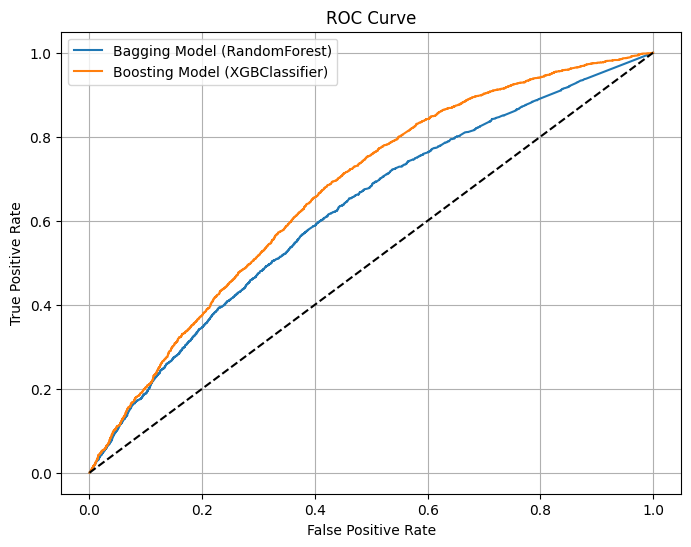

In [24]:
'''T9. Plot ROC-curve.'''
# YOUR CODE HERE
y_val_pred_bag = model_bag.predict_proba(X_val)[:, 1]

# Generate predictions for boosting model
y_val_pred_boost = model_boost.predict_proba(X_val)[:, 1]

# Compute ROC curve for bagging model
fpr_bag, tpr_bag, _ = roc_curve(y_val, y_val_pred_bag)

# Compute ROC curve for boosting model
fpr_boost, tpr_boost, _ = roc_curve(y_val, y_val_pred_boost)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_bag, tpr_bag, label='Bagging Model (RandomForest)')
plt.plot(fpr_boost, tpr_boost, label='Boosting Model (XGBClassifier)')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`.

In [25]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
chosen_model = model_boost  # Change this to model_bag if you prefer the bagging model

# Generate predictions on validation data
y_val_pred = chosen_model.predict(X_val)

# Create a classification report
model_cr = classification_report(y_val, y_val_pred)

# Print the classification report
print(model_cr)

              precision    recall  f1-score   support

           0       0.72      0.95      0.82      7092
           1       0.49      0.11      0.17      2997

    accuracy                           0.70     10089
   macro avg       0.60      0.53      0.50     10089
weighted avg       0.65      0.70      0.63     10089



**Task 10 Testing**

In [26]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [27]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
from sklearn.inspection import permutation_importance

# Assuming chosen_model, X_val, and y_val are already defined and available
result = permutation_importance(chosen_model, X_val, y_val, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
permutation_importances = pd.DataFrame({
    'mean_importance': result['importances_mean'],
    'std_importance': result['importances_std']
}, index=X_val.columns)

# Select the top 7 features based on mean importance
permutation_importances = permutation_importances.nlargest(7, 'mean_importance')

# Ensure the DataFrame has the desired shape
assert permutation_importances.shape == (7, 2), "The shape of permutation_importances is not (7, 2)."

# Display the permutation importances DataFrame
print(permutation_importances)

# Display the shape to verify
print(permutation_importances.shape)

                 mean_importance  std_importance
Inspection Type         0.013639        0.001912
Latitude                0.007246        0.001779
Longitude               0.004440        0.002202
Zip                     0.003687        0.001253
Facility Type           0.003390        0.001313
Risk                    0.001467        0.000762
City                    0.000010        0.000136
(7, 2)


**Task 11 Testing**

In [29]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

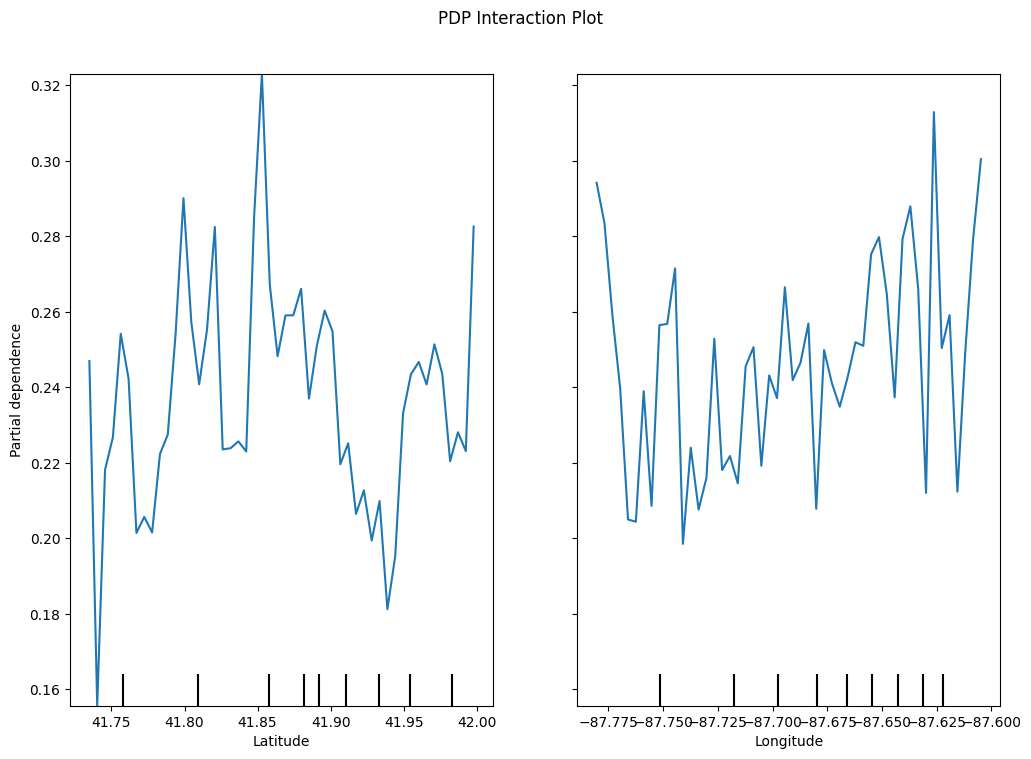

In [30]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''

X_val_no_na = X_val.dropna()

# Define the features for the interaction plot
features = ['Latitude', 'Longitude']

# Create the PDP interaction plot
fig, ax = plt.subplots(figsize=(12, 8))
plot_partial_dependence(
    estimator=chosen_model,  # Use your chosen model here
    X=X_val_no_na,
    features=features,
    grid_resolution=50,
    ax=ax  # Use ax to plot on the same figure
)

plt.suptitle('PDP Interaction Plot')
plt.subplots_adjust(top=0.9)  # Adjust the top margin for the title
plt.show()

What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.

By examining the PDP interaction plot, we can identify specific geographic areas that are more prone to failing food safety inspections. This information is valuable for targeting interventions and improving food safety practices in higher-risk locations.If the PDP interaction plot shows clear variations based on latitude and longitude, it supports the hypothesis that there is a relationship between location and the likelihood of failing a food safety inspection. On the other hand, if the plot is relatively flat and shows little variation, it would suggest that location might not be a significant factor in failing the inspections.Without the exact plot at hand, these general guidelines should help you interpret the results and draw meaningful conclusions about the relationship between location and food safety inspection outcomes.